In [1]:
import torch
from simple_vit import SimpleVisionTransformer

In [2]:
hidden_dim = 384
input_resolution = 224

vit = SimpleVisionTransformer(
    image_size=input_resolution,
    patch_size=16,
    num_layers=12,
    num_heads=6,
    hidden_dim=hidden_dim,
    mlp_dim=hidden_dim * 4
)

In [3]:
ckpt_path = "/data/imagenet-runs/logs/90ep-repo-attempt12/checkpoints/model_best.pth.tar"
# ckpt_path = "/data/imagenet-runs/logs/90ep-true-reproduction/checkpoints/model_best.pth.tar"

ckpt = torch.load(ckpt_path, weights_only=True)
ckpt['step'], ckpt['best_acc1']

(110000, 0.7728800002169609)

In [4]:
vit.load_state_dict({k[len('module.'):]: v for k, v in ckpt['state_dict'].items()})

<All keys matched successfully>

In [5]:
def gelu_hook_function(module, grad_in, grad_out):
    return (torch.clamp(grad_in[0], min=0.),)

In [6]:
handles = []

for name, m in vit.named_modules():
    if isinstance(m, torch.nn.GELU):
        print(name)
        # handles.append(m.register_full_backward_hook(gelu_hook_function))

encoder.layers.encoder_layer_0.mlp.1
encoder.layers.encoder_layer_1.mlp.1
encoder.layers.encoder_layer_2.mlp.1
encoder.layers.encoder_layer_3.mlp.1
encoder.layers.encoder_layer_4.mlp.1
encoder.layers.encoder_layer_5.mlp.1
encoder.layers.encoder_layer_6.mlp.1
encoder.layers.encoder_layer_7.mlp.1
encoder.layers.encoder_layer_8.mlp.1
encoder.layers.encoder_layer_9.mlp.1
encoder.layers.encoder_layer_10.mlp.1
encoder.layers.encoder_layer_11.mlp.1


In [7]:
import torchvision.datasets as datasets
from torchvision.transforms import v2

data = "/data/ImageNet/"
value_range = v2.Normalize(
    mean=[0.5] * 3,
    std=[0.5] * 3
)

val_dataset = datasets.ImageNet(
    data,
    split='val',
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize(256),
        v2.CenterCrop(input_resolution),
        v2.ToDtype(torch.float32, scale=True),
        value_range,
    ])
)

In [8]:
batch_size = 32

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True, sampler=None,
    multiprocessing_context='spawn'
)

In [9]:
device = torch.device("cuda")
vit = vit.to(device)

In [10]:
_, batch = next(enumerate(val_loader))
images, target = batch
images = images.to(device)
target = target.to(device)
images.requires_grad = True
logits = vit(images)

In [11]:
logits

tensor([[ 8.3346e+00,  1.0982e+00,  6.2440e+00,  ...,  3.1200e+00,
         -3.1170e-01, -8.8689e-02],
        [ 8.9488e+00,  1.8707e+00,  5.9982e-01,  ..., -7.3052e-03,
          1.5040e+00, -1.3603e+00],
        [ 9.5773e+00, -2.1971e-01,  1.5921e-01,  ...,  4.7118e-01,
          1.4590e+00, -2.2043e+00],
        ...,
        [ 9.1267e+00,  1.9778e+00,  5.0452e-01,  ...,  3.6752e+00,
          1.2223e+00, -7.8004e-01],
        [ 1.1209e+01,  1.7953e+00,  5.6650e-01,  ...,  1.9065e+00,
          1.0025e+00, -9.1322e-01],
        [ 1.3884e+01,  2.2045e+00,  1.3911e+00,  ...,  1.8760e+00,
          1.2244e+00, -7.0228e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [12]:
target

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [13]:
target_logits = logits[torch.arange(logits.shape[0]), target]

In [14]:
target_logits

tensor([ 8.3346,  8.9488,  9.5773, 12.3376, 10.8527, 10.5585, 10.6806, 11.0352,
        11.7876,  9.6538,  3.1012,  9.4093, 12.2938, 13.8391,  9.4923, 14.7734,
        12.0989,  8.5995, 11.4519, 14.8783, 12.2630, 13.1739, 10.9130, 15.6440,
        12.9963, 13.4786, 10.0738, 13.5317, 10.0982,  9.1267, 11.2093, 13.8842],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [15]:
total = sum(target_logits)
total.backward()

In [16]:
grad_sum_clipped = torch.clamp(images.grad.sum(dim=1), min=0.)

In [17]:
grad_sum_clipped_normalized = grad_sum_clipped / grad_sum_clipped.amax(dim=(1, 2), keepdim=True)

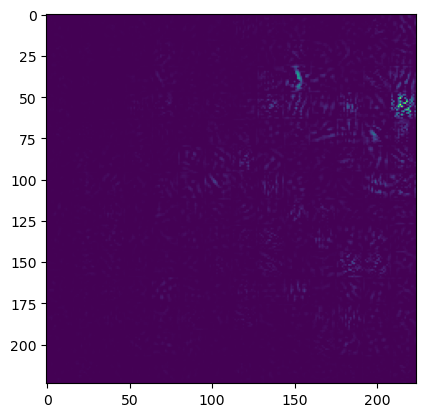

In [18]:
import matplotlib.pyplot as plt
plt.imshow(grad_sum_clipped_normalized[0].cpu())

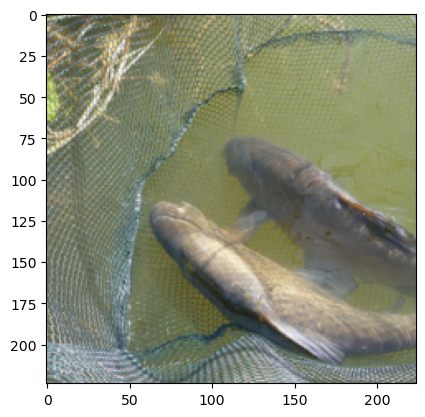

In [19]:
original_images = (images / 2 + 0.5).detach().permute(0, 2, 3, 1).cpu().numpy()
plt.imshow(original_images[0])

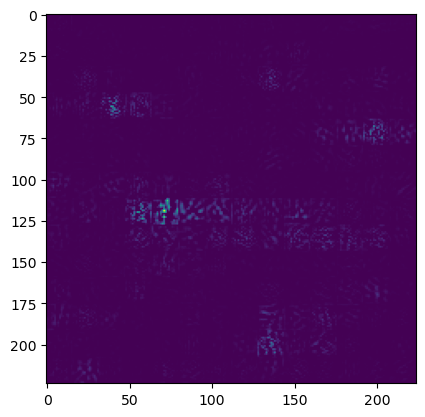

In [20]:
plt.imshow(grad_sum_clipped_normalized[1].cpu())

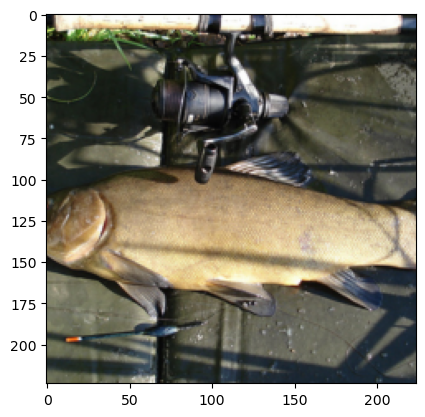

In [21]:
plt.imshow(original_images[1])

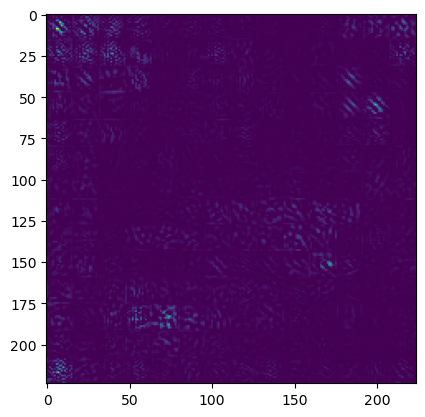

In [22]:
plt.imshow(grad_sum_clipped_normalized[-1].cpu())

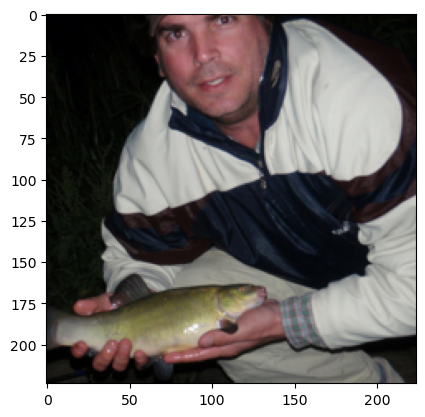

In [23]:
plt.imshow(original_images[-1])